In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 加载数据
data_path = './模型1.csv'
data = pd.read_csv(data_path)
df_close = data['Close'].values.reshape(-1, 1)

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_close)

# 创建时间序列数据集
def create_dataset(dataset, look_back=20, forecast_horizon=5):
    X, Y = [], []
    for i in range(len(dataset) - look_back - forecast_horizon + 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[(i + look_back):(i + look_back + forecast_horizon), 0])
    return np.array(X), np.array(Y)

look_back = 20
forecast_horizon = 5
X, Y = create_dataset(scaled_data, look_back, forecast_horizon)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# 调整数据形状
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 构建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(25))
model.add(Dense(forecast_horizon))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

2024-02-18 22:09:10.945558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 22:09:10.994724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 22:09:10.995551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 22:09:11.793399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100
63/63 [==============================] - 5s 31ms/step - loss: 0.0197 - val_loss: 0.0041
Epoch 2/100
63/63 [==============================] - 1s 17ms/step - loss: 7.1449e-04 - val_loss: 0.0033
Epoch 3/100
63/63 [==============================] - 1s 16ms/step - loss: 6.4791e-04 - val_loss: 0.0030
Epoch 4/100
63/63 [==============================] - 1s 16ms/step - loss: 6.3933e-04 - val_loss: 0.0034
Epoch 5/100
63/63 [==============================] - 1s 16ms/step - loss: 6.0006e-04 - val_loss: 0.0033
Epoch 6/100
63/63 [==============================] - 1s 16ms/step - loss: 6.6983e-04 - val_loss: 0.0031
Epoch 7/100
63/63 [==============================] - 1s 16ms/step - loss: 6.6010e-04 - val_loss: 0.0038
Epoch 8/100
63/63 [==============================] - 1s 16ms/step - loss: 5.9421e-04 - val_loss: 0.0030
Epoch 9/100
63/63 [==============================] - 1s 16ms/step - loss: 6.1619e-04 - val_loss: 0.0036
Epoch 10/100
63/63 [==============================] - 1s 16ms/step -

16/16 [==============================] - 0s 5ms/step
MSE: 35.26033742688146, RMSE: 5.938041548093231


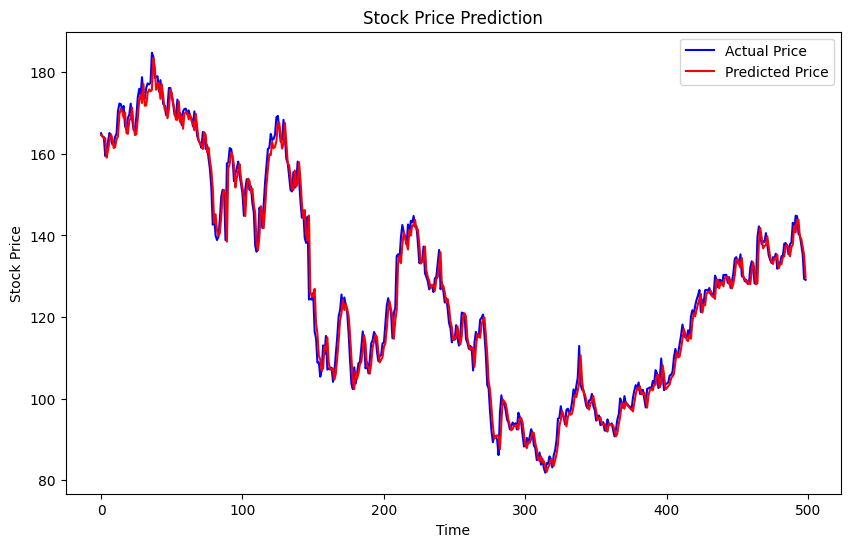

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# 假设模型已经训练好，并且已经定义了X_test和scaler

# 使用模型进行预测
predicted_prices = model.predict(X_test)

# 反标准化预测结果和实际值
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(Y_test.reshape(-1, 5))

# 计算预测准确性指标
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, RMSE: {rmse}')

# 可视化预测结果与实际价格的比较
plt.figure(figsize=(10, 6))
plt.plot(actual_prices[:, 0], label='Actual Price', color='blue')
plt.plot(predicted_prices[:, 0], label='Predicted Price', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [6]:
# 假定最后20天的数据已经准备好，并且调整为适合模型输入的形状
last_20_days_scaled = scaled_data[-20:].reshape(1, 20, 1)

# 使用模型进行未来5天的股票价格预测
predicted_next_5_days_scaled = model.predict(last_20_days_scaled)

# 反标准化预测结果，以获取预测的原始股票价格
predicted_next_5_days = scaler.inverse_transform(predicted_next_5_days_scaled).flatten()

# 打印预测的股票价格
print("Predicted stock prices for the next 5 days:", predicted_next_5_days)

# 如果有实际的股票价格数据可用，也可以打印出来进行比较
# 假设actual_next_5_days是未来5天的实际股票价格数组
# actual_next_5_days = np.array([实际价1, 实际价2, 实际价3, 实际价4, 实际价5])
# print("Actual stock prices for the next 5 days:", actual_next_5_days)

1/1 [==============================] - 0s 17ms/step
Predicted stock prices for the next 5 days: [126.2648  126.37712 127.50142 127.59339 129.88431]


In [10]:
# 假定scaled_data是已经标准化的整个数据集

# 准备最后一批测试数据
last_20_days_scaled = scaled_data[-20:].reshape(1, 20, 1)

# 使用模型进行未来5天的股票价格预测
predicted_next_5_days_scaled = model.predict(last_20_days_scaled)

# 反标准化预测结果
predicted_next_5_days = scaler.inverse_transform(predicted_next_5_days_scaled).flatten()

# 获取对应的未来5天的实际股票价格（如果可用）
# 假设你的原始数据集中包含这5天的数据，这里我们需要手动指定这些实际值
# 例如，如果这些数据位于数据集的最末尾，则可以直接获取
actual_next_5_days = data['Close'][-5:].values  # 假设这是可用的实际值

# 打印预测的股票价格
print("Predicted stock prices for the next 5 days:", predicted_next_5_days)

# 打印实际的股票价格以进行比较（如果实际数据可用）
print("Actual stock prices for the next 5 days:", actual_next_5_days)

1/1 [==============================] - 0s 17ms/step
Predicted stock prices for the next 5 days: [126.2648  126.37712 127.50142 127.59339 129.88431]
Actual stock prices for the next 5 days: [129.119995 131.270004 125.980003 125.980003 125.980003]
